<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Blogs/Borealis_NNGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code replicates most of the results from the Borealis blog on the Neural Network Gaussian Process.  Please mail errata to udlbookmail@gmail.com.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import cm
from matplotlib.colors import ListedColormap
import scipy.special as sci
from scipy.stats import norm

Routines to draw an ellipes representing the covariance of a Gaussian.

In [2]:
# Draws confidence ellipse corrsponding to mean and covariance onto axis 'ax'
def confidence_ellipse(mean_x, mean_y, cov, ax, n_std=2.0, facecolor='none', **kwargs):

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std


    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Draws confidence ellipse corresponding to x and y data onto axis 'ax'
def confidence_ellipse_data(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    return confidence_ellipse(mean_x, mean_y, cov, ax, n_std, facecolor, **kwargs)

Create a random shallow network (i.e. with a single hidden layer) with $D$ hidden units and ReLU activation functions.  Note network definition is different from usual in that it normalizes output by $\sqrt{D}$.

In [3]:
# Creates a neural network initialized with random parameters
class RandomShallowNetwork:
  def __init__(self, d_in, d_out, n_hidden,  sigma_beta, sigma_omega, seed=None):
    self.d_in = d_in
    self.d_out = d_out
    self.n_hidden = n_hidden
    if seed is not None:
      np.random.seed(seed)

    self.Omega_0 = np.random.normal(size=(n_hidden, d_in)) * sigma_omega
    self.beta_0 = np.random.normal(size=(n_hidden,1)) * sigma_beta
    self.Omega_1 = np.random.normal(size=(d_out, n_hidden)) * sigma_omega
    self.beta_1 = np.random.normal(size=(d_out,1)) * sigma_beta

  # Standard ReLU function
  def ReLU(self, preactivation):
    activation = preactivation.clip(0.0)
    return activation

  # Standard forward definition of network
  def forward(self, X):
    n_data = X.shape[1]
    preactivations = self.Omega_0 @ X  + self.beta_0 @ np.ones((1,n_data))
    activations = self.ReLU(preactivations)
    outputs = self.Omega_1 @ activations / np.sqrt(self.n_hidden) + self.beta_1 @ np.ones((1,n_data))
    return outputs, activations, preactivations

Initialize 1000 random neural networks and run them on an equally-spaced set of data points.  Store the preactivation at the first neuron, the activation at the first neuron and the output.

In [4]:
x = np.arange(-3,3, 0.01)
x = x[None,:]
n_data=x.shape[1]

n_network = 1000
outputs_all = np.zeros((n_network, n_data))
preactivation_1_all = np.zeros((n_network, n_data))
activation_1_all = np.zeros((n_network, n_data))

sigma_beta = 0.5
sigma_omega = 1.0
n_hidden = 1000

for c_network in range(n_network):
  network = RandomShallowNetwork(d_in=1,d_out=1, n_hidden=n_hidden,  seed=c_network, sigma_beta = sigma_beta, sigma_omega = sigma_omega)
  outputs, activations, preactivations = network.forward(x)
  outputs_all[c_network,:] = outputs
  preactivation_1_all[c_network,:] = preactivations[0,:]
  activation_1_all[c_network,:] = activations[0,:]

Plot the preactivations at first neuron, activations at first neuron, and network outputs.

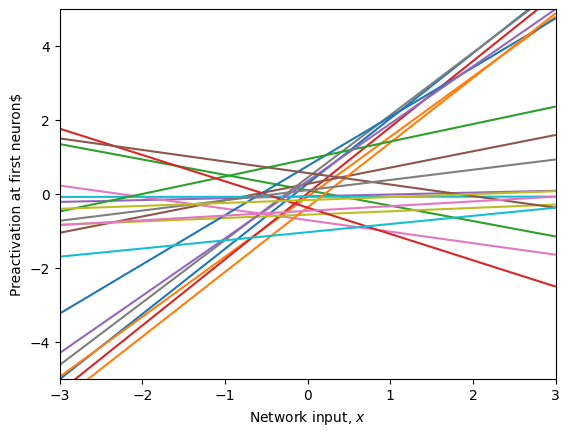

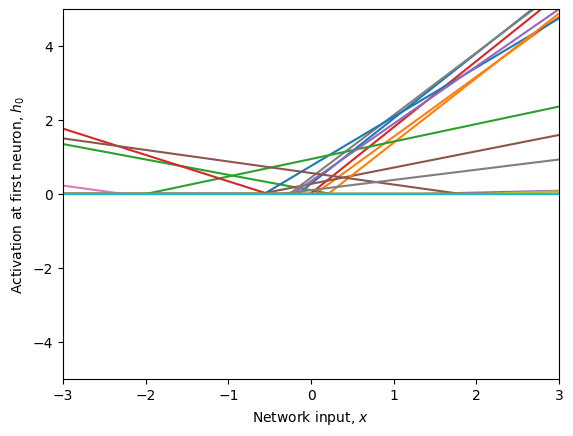

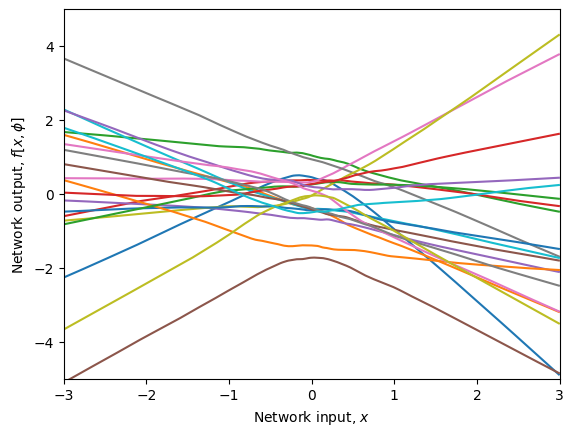

In [5]:
# Plot the preactivations of the first neuron in 20 diferent networks as a function of the input value
fig, ax = plt.subplots()
for c_network in range(20):
  ax.plot(np.squeeze(x), preactivation_1_all[c_network,:])
ax.set_xlim([-3,3])
ax.set_ylim([-5,5])
ax.set_xlabel('Network input, $x$')
ax.set_ylabel('Preactivation at first neuron$')
plt.show()

# Plot the activations of the first neuron in 20 diferent networks as a function of the input value
fig, ax = plt.subplots()
for c_network in range(20):
  ax.plot(np.squeeze(x), activation_1_all[c_network,:])
ax.set_xlim([-3,3])
ax.set_ylim([-5,5])
ax.set_xlabel('Network input, $x$')
ax.set_ylabel('Activation at first neuron, $h_0$')
plt.show()

# Plot the output of the first neuron in 20 diferent networks as a function of the input value
fig, ax = plt.subplots()
for c_network in range(20):
  ax.plot(np.squeeze(x), outputs_all[c_network,:])
ax.set_xlim([-3,3])
ax.set_ylim([-5,5])
ax.set_xlabel('Network input, $x$')
ax.set_ylabel('Network output, $f[x,\phi]$')
plt.show()

Plot mean and covariance of the preactivations

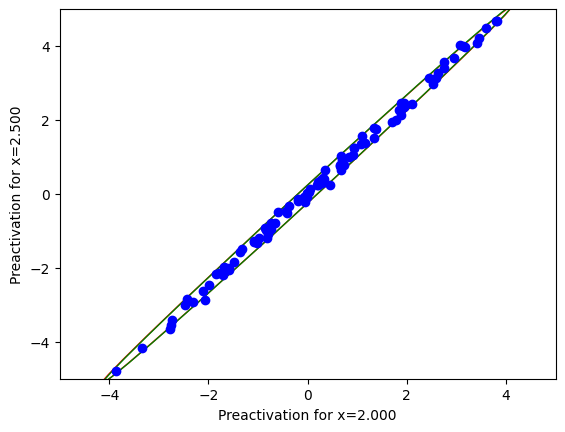

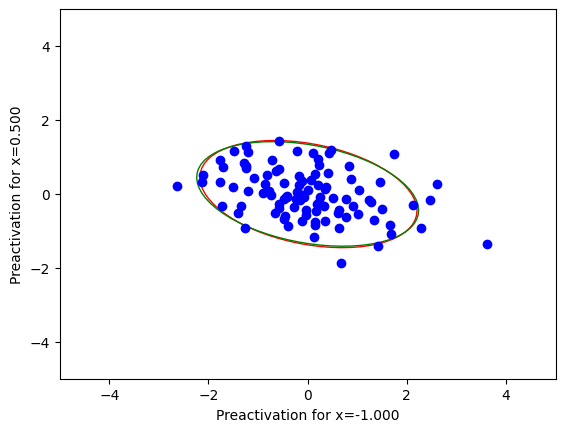

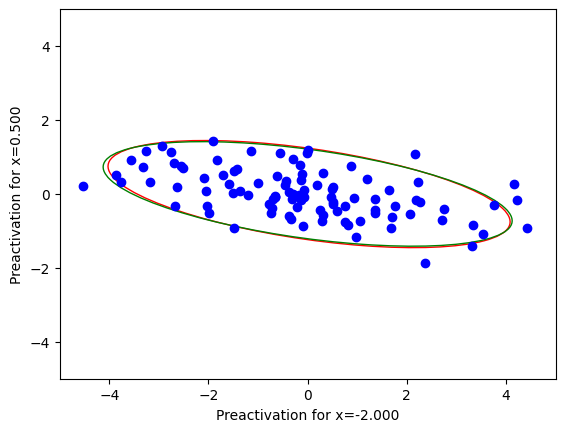

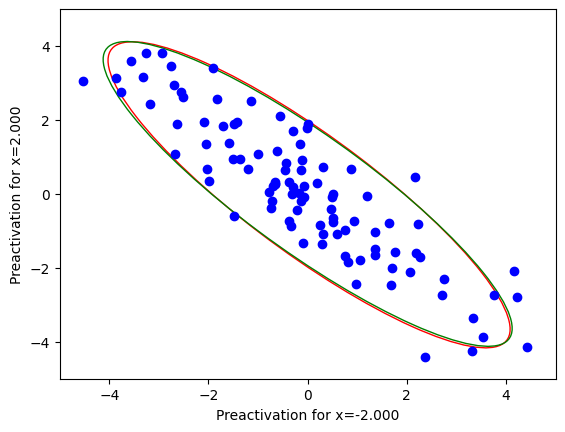

In [6]:
def plot_scatter_preactivation(x, activation_1_all, index1, index2, sigma_beta=None, sigma_omega=None):
  fig, ax = plt.subplots()
  ax.plot(np.squeeze(activation_1_all[0:100,index1]), np.squeeze(activation_1_all[0:100,index2]),'bo')
  ax.set_xlabel('Preactivation for x=%3.3f'%(x[0,index1]))
  ax.set_ylabel('Preactivation for x=%3.3f'%(x[0,index2]))
  ax.set_xlim([-5,5])
  ax.set_ylim([-5,5])
  confidence_ellipse_data(np.squeeze(activation_1_all[:,index1]), np.squeeze(activation_1_all[:,index2]), ax, edgecolor='red')
  x1 = np.ones((1,1)) * x[0,index1]
  x2 = np.ones((1,1)) * x[0,index2]
  predicted_mean = np.zeros((2,1))
  predicted_cov = np.zeros((2,2))
  predicted_cov[0,0] = x1[0,0] * x1[0,0] * sigma_omega * sigma_omega + sigma_beta * sigma_beta
  predicted_cov[1,0] = x2[0,0] * x1[0,0] * sigma_omega * sigma_omega + sigma_beta * sigma_beta
  predicted_cov[0,1] = x1[0,0] * x2[0,0] * sigma_omega * sigma_omega + sigma_beta * sigma_beta
  predicted_cov[1,1] = x2[0,0] * x2[0,0] * sigma_omega * sigma_omega + sigma_beta * sigma_beta
  confidence_ellipse(predicted_mean[0,0], predicted_mean[1,0], predicted_cov, ax, edgecolor='green')
  plt.show()

# Plot the correlation between activations at two particular positions for the networks
# Plot the empirical covariance (red ellipse)
# Plot the theoretical covariance (green ellipse)
plot_scatter_preactivation(x, preactivation_1_all,500,550, sigma_beta, sigma_omega)
plot_scatter_preactivation(x, preactivation_1_all,200,350, sigma_beta, sigma_omega)
plot_scatter_preactivation(x, preactivation_1_all,100,350, sigma_beta, sigma_omega)
plot_scatter_preactivation(x, preactivation_1_all,100,500, sigma_beta, sigma_omega)

Routines for calculating the expected value and covariance of activations at hidden unit.

In [7]:
# Return theoretical covariance of activations
def hidden_unit_kernel(x1,x2, sigma_sq_b, sigma_sq_w):
  Kx1x1 = np.sum(x1*x1)*sigma_sq_w+sigma_sq_b
  Kx2x2 = np.sum(x2*x2)*sigma_sq_w+sigma_sq_b
  Kx1x2 = np.sum(x1*x2)*sigma_sq_w+sigma_sq_b
  norm1 = np.sqrt(Kx1x1)
  norm2 = np.sqrt(Kx2x2)

  # Deal with degenerate case
  if norm1 < 1e-10 or norm2 < 1e-10 :
    theta = 0
  else:
    if np.array_equal(x1,x2):
      theta = 0
    else:
      theta = np.arccos(Kx1x2/(norm1 * norm2))
  angle_fac = (np.sin(theta)+(np.pi-theta)*np.cos(theta))
  D_i = x1.shape[0]

  cov_val = (1 / (2*np.pi))*norm1 * norm2 * angle_fac
  return cov_val


# Computes second moment at hidden unit
def hidden_unit_second_moment(x1,x2, sigma_sq_b, sigma_sq_w):
  cov_out = np.zeros((2,2))
  cov_out[0,0] = hidden_unit_kernel(x1,x1, sigma_sq_b, sigma_sq_w)
  cov_out[0,1] = hidden_unit_kernel(x2,x1, sigma_sq_b, sigma_sq_w)
  cov_out[1,0] = hidden_unit_kernel(x1,x2, sigma_sq_b, sigma_sq_w)
  cov_out[1,1] = hidden_unit_kernel(x2,x2, sigma_sq_b, sigma_sq_w)
  return cov_out

def expected_relu(mean,sigma):
  z = mean / sigma
  return sigma * (norm.pdf(z,0,1) + z * norm.cdf(z,0,1))

# Compute mean and covariance between values at first hidden unit for inputs x1 and x2 if given standard deviation of weights and bias
def compute_hidden_mean_covariance(x1,x2, sigma_beta, sigma_omega):
  predicted_mean = np.ones((2,1))
  predicted_mean[0,0] = expected_relu(0.0, np.sqrt(x1[0,0] * x1[0,0] * sigma_omega * sigma_omega + sigma_beta * sigma_beta))
  predicted_mean[1,0] = expected_relu(0.0, np.sqrt(x2[0,0] * x2[0,0] * sigma_omega * sigma_omega + sigma_beta * sigma_beta))

  predicted_second_mom = hidden_unit_second_moment(x1,x2, sigma_sq_b=sigma_beta*sigma_beta, sigma_sq_w = sigma_omega*sigma_omega)
  predicted_cov = predicted_second_mom - predicted_mean @ predicted_mean.transpose()
  return predicted_mean, predicted_cov, predicted_second_mom

Plot the mean and covariance of the activations

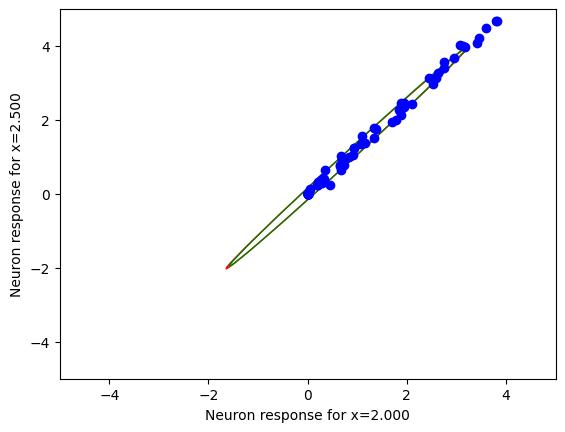

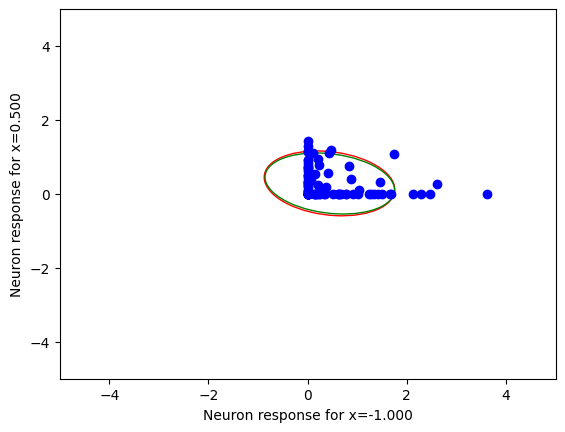

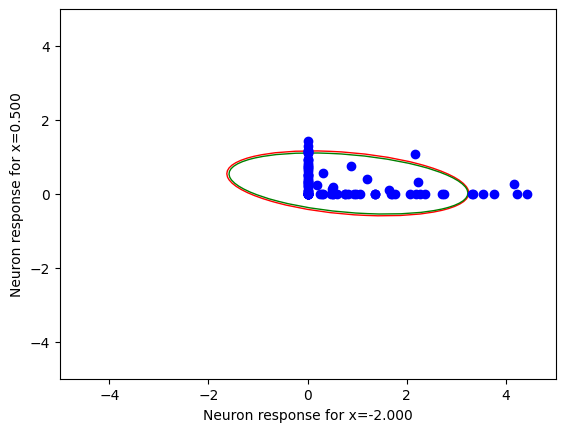

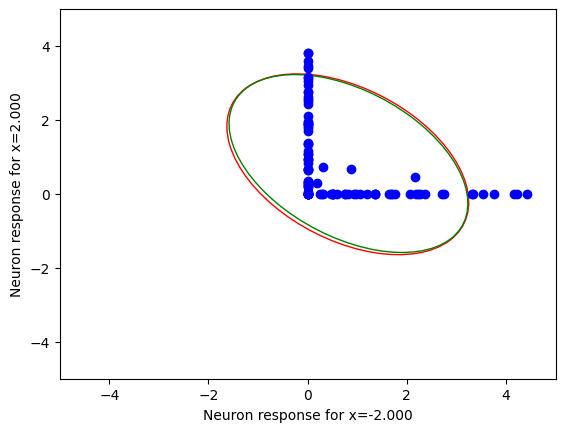

In [8]:
def plot_scatter_activation(x, activation_1_all, index1, index2, sigma_beta=None, sigma_omega=None):
  fig, ax = plt.subplots()
  ax.plot(np.squeeze(activation_1_all[0:100,index1]), np.squeeze(activation_1_all[0:100,index2]),'bo')
  ax.set_xlabel('Neuron response for x=%3.3f'%(x[0,index1]))
  ax.set_ylabel('Neuron response for x=%3.3f'%(x[0,index2]))
  ax.set_xlim([-5,5])
  ax.set_ylim([-5,5])
  confidence_ellipse_data(np.squeeze(activation_1_all[:,index1]), np.squeeze(activation_1_all[:,index2]), ax, edgecolor='red')
  x1 = np.ones((1,1)) * x[0,index1]
  x2 = np.ones((1,1)) * x[0,index2]
  predicted_mean, predicted_cov, predicted_second_mom = compute_hidden_mean_covariance(x1,x2, sigma_beta, sigma_omega)
  confidence_ellipse(predicted_mean[0,0], predicted_mean[1,0], predicted_cov, ax, edgecolor='green')
  plt.show()

# Plot the correlation between activations at two particular positions for the networks
# Plot the empirical covariance (red ellipse)
# Plot the theoretical covariance (green ellipse)
plot_scatter_activation(x, activation_1_all,500,550, sigma_beta, sigma_omega)
plot_scatter_activation(x, activation_1_all,200,350, sigma_beta, sigma_omega)
plot_scatter_activation(x, activation_1_all,100,350, sigma_beta, sigma_omega)
plot_scatter_activation(x, activation_1_all,100,500, sigma_beta, sigma_omega)

Plot mean and covariance of ouputs

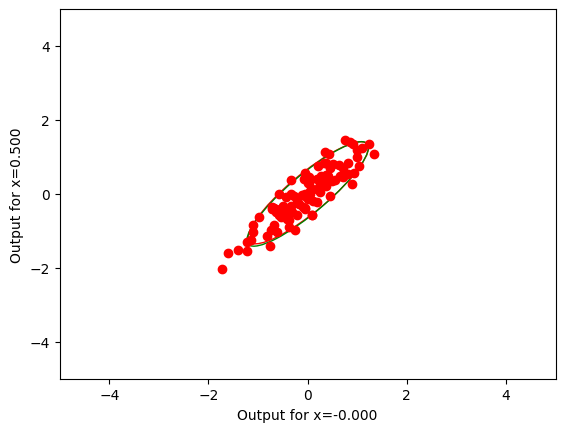

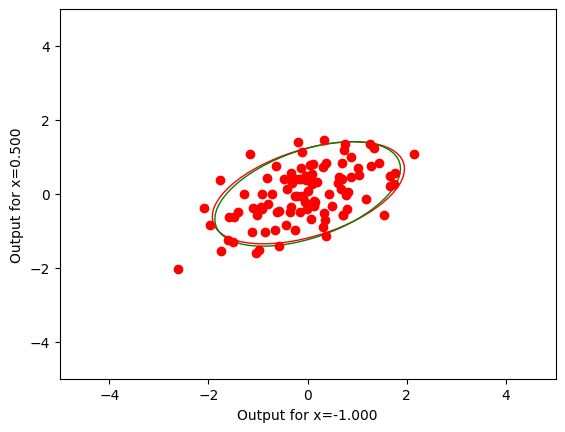

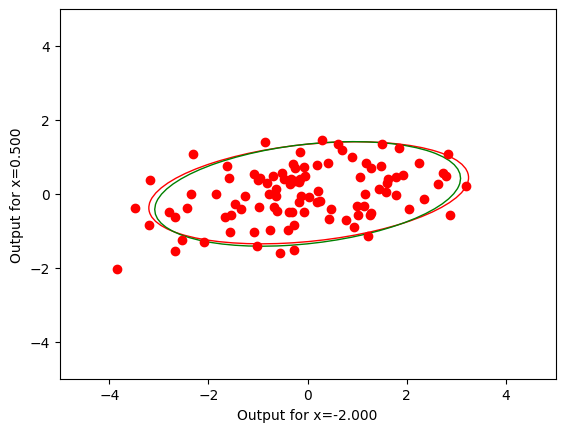

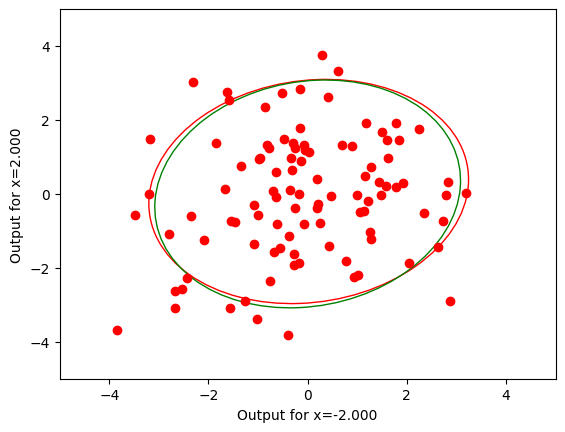

In [9]:
def plot_scatter(x, outputs_all, index1, index2, sigma_beta, sigma_omega, n_hidden):
  fig, ax = plt.subplots()
  ax.plot(np.squeeze(outputs_all[0:100,index1]), np.squeeze(outputs_all[0:100,index2]),'ro')
  ax.set_xlabel('Output for x=%3.3f'%(x[0,index1]))
  ax.set_ylabel('Output for x=%3.3f'%(x[0,index2]))
  ax.set_xlim([-5,5])
  ax.set_ylim([-5,5])
  confidence_ellipse_data(np.squeeze(outputs_all[:,index1]), np.squeeze(outputs_all[:,index2]), ax, edgecolor='red')

  x1 = np.ones((1,1)) * x[0,index1]
  x2 = np.ones((1,1)) * x[0,index2]
  predicted_mean_hidden, predicted_cov_hidden, predicted_second_mom_hidden = compute_hidden_mean_covariance(x1,x2, sigma_beta, sigma_omega)
  predicted_cov_output = predicted_second_mom_hidden * sigma_omega * sigma_omega + sigma_beta * sigma_beta
  confidence_ellipse(0, 0, predicted_cov_output, ax, edgecolor='green')
  plt.show()

# Show scatter plot of outputs together with true distribution (red) and theoretical distribution (blue)
plot_scatter(x, outputs_all,300,350, sigma_beta, sigma_omega, n_hidden)
plot_scatter(x, outputs_all,200,350, sigma_beta, sigma_omega, n_hidden)
plot_scatter(x, outputs_all,100,350, sigma_beta, sigma_omega, n_hidden)
plot_scatter(x, outputs_all,100,500, sigma_beta, sigma_omega, n_hidden)

Draw the kernel for equally spaced range of input values

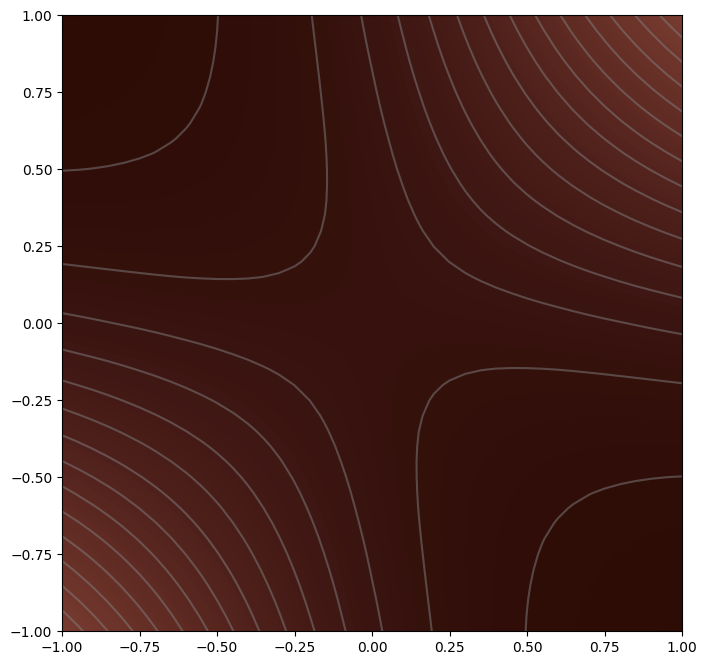

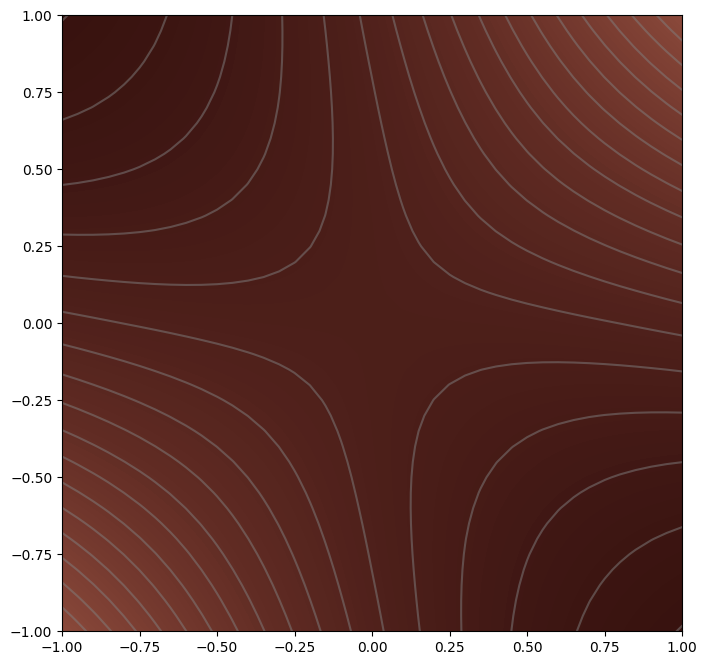

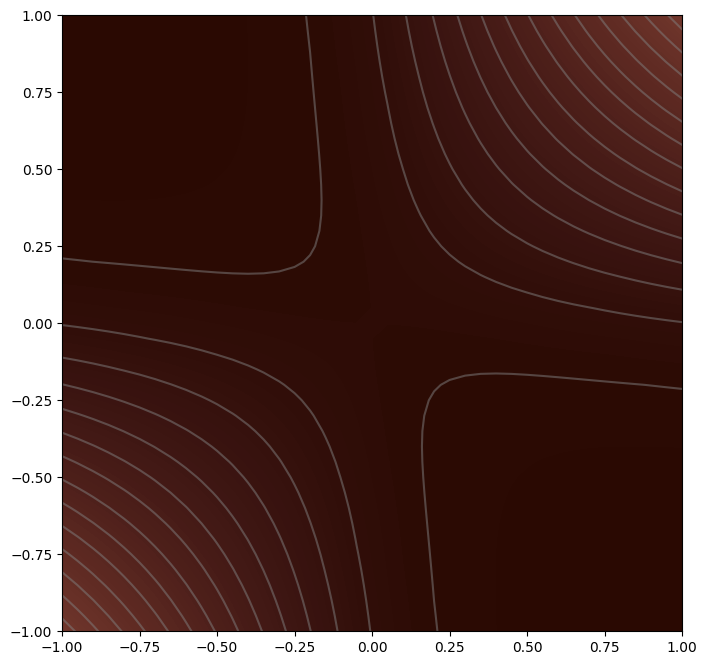

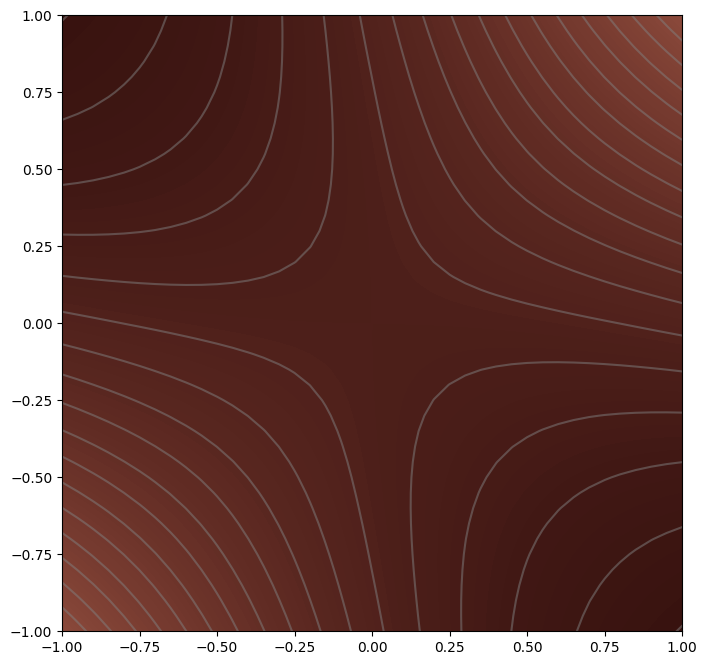

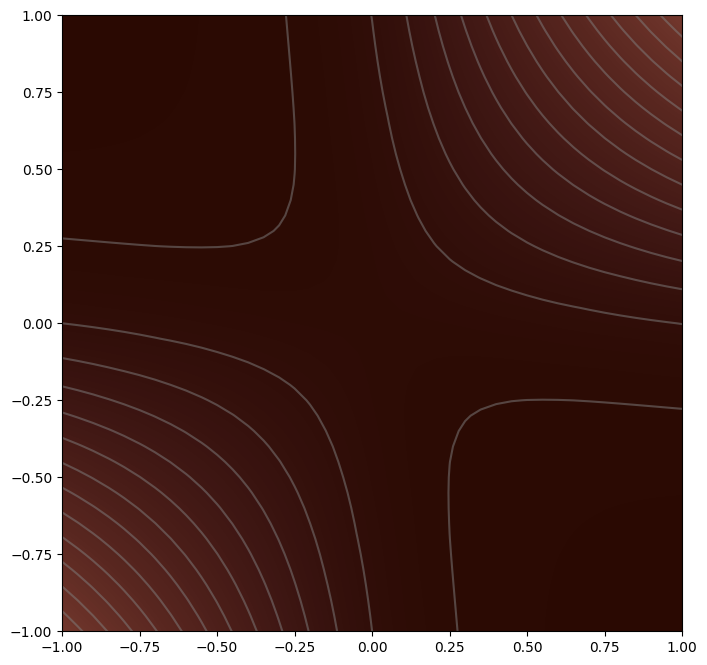

In [10]:
def plot_kernel(sigma_beta, sigma_omega, filename, n_contour =20):
  # Define pretty colormap
  my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
  my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
  r = np.floor(my_colormap_vals_dec/(256*256))
  g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
  b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
  my_colormap = ListedColormap(np.vstack((r,g,b)).transpose()/255.0)

  # Make grid of intercept/slope values to plot
  x1_mesh, x2_mesh = np.meshgrid(np.arange(-2,2,0.05), np.arange(-2,2, 0.05))
  kernel_mesh = np.zeros_like(x1_mesh)

  for idx, x1 in np.ndenumerate(x1_mesh):
    x2 = x2_mesh[idx]
    predicted_mean_hidden, predicted_cov_hidden, predicted_second_mom_hidden = compute_hidden_mean_covariance(np.ones((1,1))*x1+1e-3,np.ones((1,1))*x2+1e-3, sigma_beta, sigma_omega)
    predicted_cov_output = predicted_second_mom_hidden * sigma_omega * sigma_omega + sigma_beta * sigma_beta
    kernel_mesh[idx] = predicted_cov_output[0,1]


  fig,ax = plt.subplots()
  fig.set_size_inches(8,8)
  ax.contourf(x1_mesh,x2_mesh,kernel_mesh,256,cmap=my_colormap)
  ax.contour(x1_mesh,x2_mesh,kernel_mesh,n_contour,colors=['#80808080'])
  ax.set_xlim([-1,1])
  ax.set_ylim([-1,1])

plot_kernel(sigma_beta = 0.5, sigma_omega = 1.0, filename="kernel_05_1", n_contour=60)
plot_kernel(sigma_beta = 0.5, sigma_omega = 0.5, filename="kernel_05_5", n_contour=60)
plot_kernel(sigma_beta = 0.5, sigma_omega = 2.0, filename="kernel_05_2", n_contour=60)
plot_kernel(sigma_beta = 1.0, sigma_omega = 1.0, filename="kernel_1_1", n_contour=60)
plot_kernel(sigma_beta = 0.25, sigma_omega = 1.0, filename="kernel_025_1", n_contour=60)


Normalize the kernel and plot

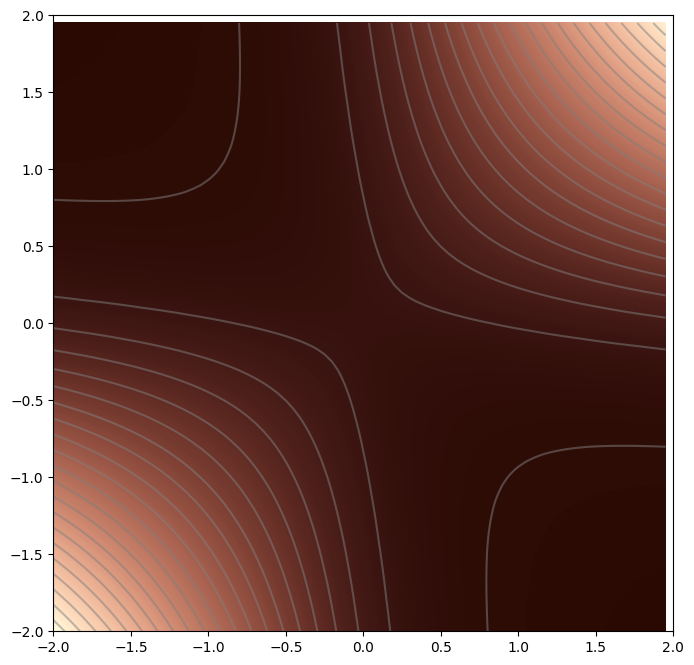

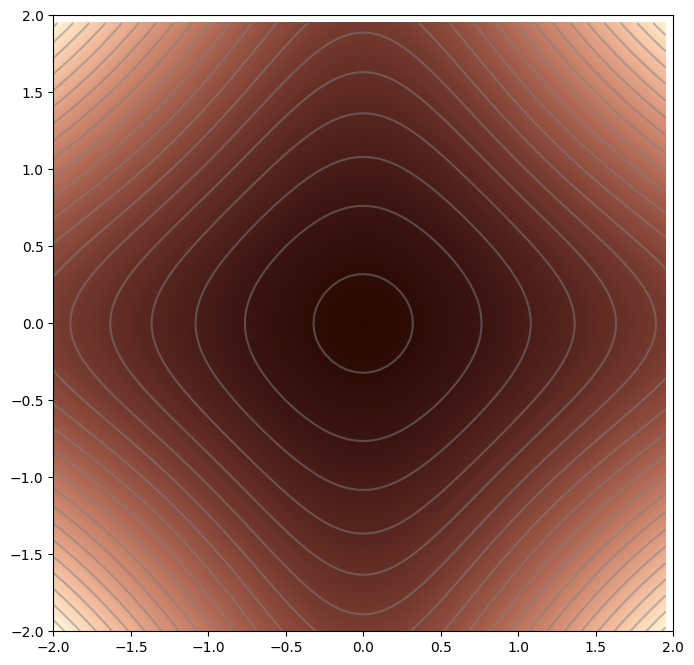

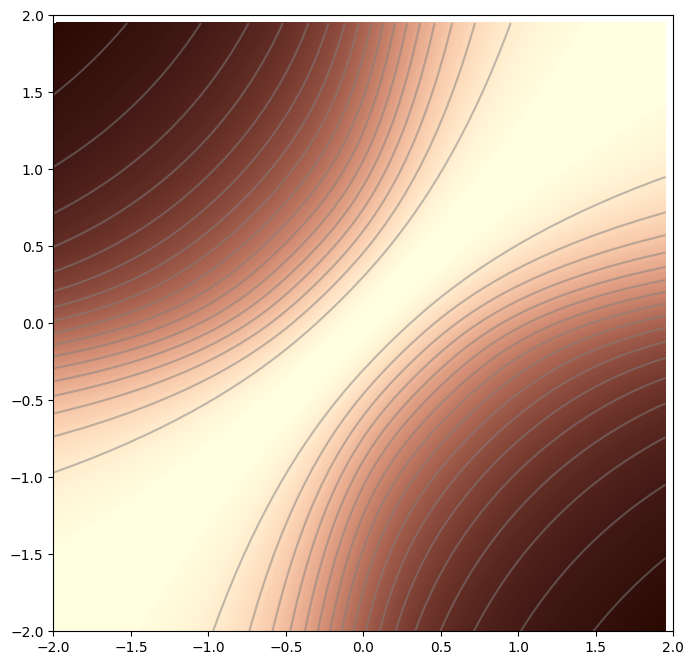

In [11]:
# Define pretty colormap
my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
r = np.floor(my_colormap_vals_dec/(256*256))
g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
my_colormap = ListedColormap(np.vstack((r,g,b)).transpose()/255.0)

# Make grid of intercept/slope values to plot
x1_mesh, x2_mesh = np.meshgrid(np.arange(-2,2,0.05), np.arange(-2,2, 0.05))
kernel_mesh = np.zeros_like(x1_mesh)
kernel_mesh_mag = np.zeros_like(x1_mesh)
kernel_mesh_norm = np.zeros_like(x1_mesh)

for idx, x1 in np.ndenumerate(x1_mesh):
  x2 = x2_mesh[idx]
  predicted_mean_hidden, predicted_cov_hidden, predicted_second_mom_hidden = compute_hidden_mean_covariance(np.ones((1,1))*x1+1e-3,np.ones((1,1))*x2+1e-3, sigma_beta, sigma_omega)
  predicted_cov_output = predicted_second_mom_hidden * sigma_omega * sigma_omega + sigma_beta * sigma_beta
  kernel_mesh[idx] = predicted_cov_output[0,1]
  kernel_mesh_mag[idx] = np.sqrt(predicted_cov_output[0,0] * predicted_cov_output[1,1])
  kernel_mesh_norm[idx] = kernel_mesh[idx] / kernel_mesh_mag[idx]

fig,ax = plt.subplots()
fig.set_size_inches(8,8)
ax.contour(x1_mesh,x2_mesh,kernel_mesh,20,colors=['#80808080'])
ax.contourf(x1_mesh,x2_mesh,kernel_mesh,256,cmap=my_colormap)
ax.set_ylim([-2,2])
ax.set_xlim([-2,2])
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

fig,ax = plt.subplots()
fig.set_size_inches(8,8)
ax.contour(x1_mesh,x2_mesh,kernel_mesh_mag,20,colors=['#80808080'])
ax.contourf(x1_mesh,x2_mesh,kernel_mesh_mag,256,cmap=my_colormap)
ax.set_ylim([-2,2])
ax.set_xlim([-2,2])
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

fig,ax = plt.subplots()
fig.set_size_inches(8,8)
ax.contour(x1_mesh,x2_mesh,kernel_mesh_norm,20,colors=['#80808080'])
ax.contourf(x1_mesh,x2_mesh,kernel_mesh_norm,256,cmap=my_colormap)
ax.set_ylim([-2,2])
ax.set_xlim([-2,2])
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

Plot cuts through kernel.

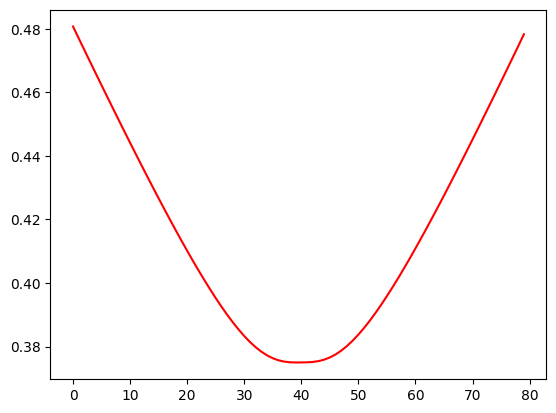

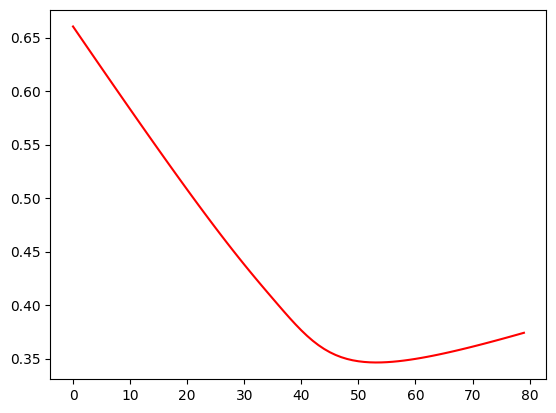

In [12]:
fig, ax = plt.subplots()
ax.plot(kernel_mesh[40,:],'r-')
plt.show()

fig, ax = plt.subplots()
ax.plot(kernel_mesh[35,:],'r-')
plt.show()

Routine for calculating NN kernel for arbitrary vectors X1, X2 of inputs

In [13]:
def shallow_kernel(X1, X2, sigma_beta, sigma_omega):
  K = np.zeros((X1.shape[1], X2.shape[1]))
  for c1 in range (X1.shape[1]):
    for c2 in range (X2.shape[1]):
      predicted_mean_hidden, predicted_cov_hidden, predicted_second_mom_hidden = compute_hidden_mean_covariance(np.ones((1,1))*X1[0,c1]+1e-3,np.ones((1,1))*X2[0,c2]+1e-3, sigma_beta, sigma_omega)
      predicted_cov_output = predicted_second_mom_hidden * sigma_omega * sigma_omega + sigma_beta * sigma_beta
      K[c1,c2] = predicted_cov_output[0,1]
  return K

Create some random data

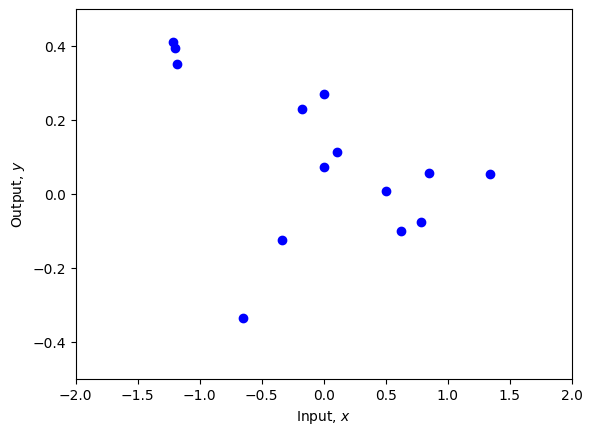

In [14]:
np.random.seed(7)
I = 15
X = np.atleast_2d(np.random.uniform(-1.4, 1.4, I))
X = np.concatenate([X, np.ones_like(X)],axis=0)
y = np.cos(X[0,:]*4.5) * np.exp((-X[0,:]/2-0.5)*2) * 0.5 + np.random.normal(size=(I)) * 0.1

fig,ax = plt.subplots()
ax.plot(X[0,:],y,'bo')
ax.set_xlim(-2.,2.)
ax.set_ylim(-.5,.5)
ax.set_xlabel('Input, $x$')
ax.set_ylabel('Output, $y$')
plt.show()

Define the NN prior and draw samples from it

In [29]:
# Define a prior over the parameters (2 dimensional as intercept + slope)
x_plot = np.atleast_2d(np.arange(-2,2,0.04))
sigma_sq_p = 0.8
sigma_sq_n = 0.002

# Prior mean and covariance for function, f
prior_func_mean = np.zeros((x_plot.shape[1], 1))
prior_func_cov = sigma_sq_p * shallow_kernel(x_plot, x_plot, sigma_beta, sigma_omega)

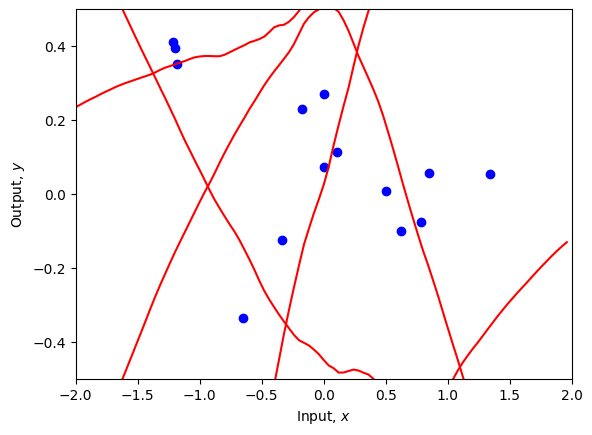

In [30]:
# Draw samples from the function prior and plot them
np.random.seed(5)
function_draws = np.random.multivariate_normal(np.squeeze(prior_func_mean), prior_func_cov, 5).T

fig,ax = plt.subplots()
ax.plot(X[0,:],y,'bo')
for i in range(function_draws.shape[1]):
  ax.plot(x_plot[0,:], function_draws[:,i].transpose(), 'r-')

ax.set_xlim(-2,2)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Input, $x$')
ax.set_ylabel('Output, $y$')
plt.show()

Compute posterior distribution

In [31]:
# Posterior mean and covariance for function, f
inv_term = np.linalg.inv(shallow_kernel(X[0:1,:], X[0:1,:], sigma_beta, sigma_omega) + (sigma_sq_n/sigma_sq_p) * np.identity(X.shape[1]))
post_func_mean = shallow_kernel(x_plot, X[0:1,:], sigma_beta, sigma_omega) @ inv_term @ y
post_func_cov = sigma_sq_p * shallow_kernel(x_plot, x_plot, sigma_beta, sigma_omega)  - sigma_sq_p  * shallow_kernel(x_plot, X[0:1,:], sigma_beta, sigma_omega) @ inv_term @ shallow_kernel(X[0:1,:], x_plot, sigma_beta, sigma_omega)

# Posterior mean and covariance for output, y
post_output_mean = shallow_kernel(x_plot, X[0:1,:], sigma_beta, sigma_omega) @ inv_term @ y
post_output_cov = sigma_sq_p * shallow_kernel(x_plot, x_plot, sigma_beta, sigma_omega)  - sigma_sq_p  * shallow_kernel(x_plot, X[0:1,:], sigma_beta, sigma_omega) @ inv_term @ shallow_kernel(X[0:1,:], x_plot, sigma_beta, sigma_omega) + sigma_sq_n * np.identity(x_plot.shape[1])

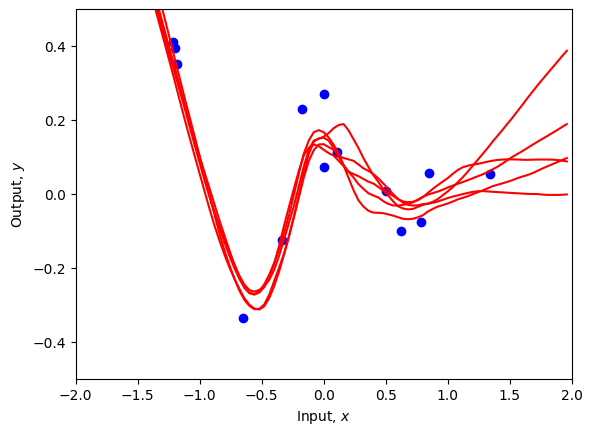

In [32]:
# Draw samples from the function posterior and plot them
np.random.seed(5)
function_draws = np.random.multivariate_normal(np.squeeze(post_func_mean), post_func_cov, 5).T

fig,ax = plt.subplots()
ax.plot(X[0,:],y,'bo')
for i in range(function_draws.shape[1]):
  ax.plot(x_plot[0,:], function_draws[:,i].transpose(), 'r-')

ax.set_xlim(-2.,2.)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Input, $x$')
ax.set_ylabel('Output, $y$')
plt.show()

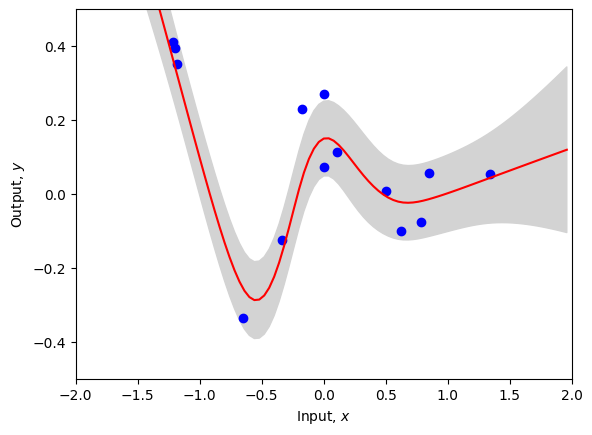

In [33]:
fig,ax = plt.subplots()
ax.plot(X[0,:],y,'bo')
post_output_cov_diag = np.diag(post_output_cov)
ax.plot(x_plot[0,:], post_output_mean,'r-')
ax.fill_between(x_plot[0,:], post_output_mean-2*np.sqrt(post_output_cov_diag), post_output_mean+2*np.sqrt(post_output_cov_diag), color='lightgray')
ax.set_xlim(-2,2)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Input, $x$')
ax.set_ylabel('Output, $y$')
plt.show()